In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# change current working directory to the root of the project
import os
os.chdir(os.path.dirname(os.getcwd()))

# Purpose
- Purpose of this notebook is to determine the optimal threshold to produce labels by maximizing G-Mean

In [2]:
from IPython.display import display
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from statsmodels.stats.contingency_tables import mcnemar

In [3]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

/var/folders/rx/jl4f7yr95xd03cgb4sg2w99h0000gn/T/ipykernel_2903/4075833985.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


# Load Predictions

In [8]:
nrows = None

# load test data
y_test = joblib.load("data/transformed/y_test.pkl")

# load baseline model 1 predictions from csv
baseline_random_rate_predictions = pd.read_csv("predictions/predictions_baseline_model_2.csv", nrows=nrows)['0']

# load LSTM model predictions from csv
lstm_model_predictions = pd.read_csv("predictions/predictions_lstm.csv", nrows=nrows)['predicted_activity']

# load cnn model predictions from csv
cnn_model_predictions = pd.read_csv("predictions/predictions_cnn.csv", nrows=nrows)['predicted_activity']

# load cnn_lstm model predictions from csv
cnn_lstm_model_predictions = pd.read_csv("predictions/predictions_cnn_lstm.csv", nrows=nrows)['predicted_activity']

In [18]:
# accuracy
print("Baseline Random Rate Accuracy: ", round(accuracy_score(y_test, baseline_random_rate_predictions), 3))
print("LSTM Accuracy: ", round(accuracy_score(y_test, lstm_model_predictions), 3))
print("CNN Accuracy: ", round(accuracy_score(y_test, cnn_model_predictions), 3))
print("CNN-LSTM Accuracy: ", round(accuracy_score(y_test, cnn_lstm_model_predictions), 3))

# precision
print("\nBaseline Random Rate Precision: ", round(precision_score(y_test, baseline_random_rate_predictions, average='weighted'), 3))
print("LSTM Precision: ", round(precision_score(y_test, lstm_model_predictions, average='weighted'), 3))
print("CNN Precision: ", round(precision_score(y_test, cnn_model_predictions, average='weighted'), 3))
print("CNN-LSTM Precision: ", round(precision_score(y_test, cnn_lstm_model_predictions, average='weighted'), 3))

# recall
print("\nBaseline Random Rate Recall: ", round(recall_score(y_test, baseline_random_rate_predictions, average='weighted'), 3))
print("LSTM Recall: ", round(recall_score(y_test, lstm_model_predictions, average='weighted'), 3))
print("CNN Recall: ", round(recall_score(y_test, cnn_model_predictions, average='weighted'), 3))
print("CNN-LSTM Recall: ", round(recall_score(y_test, cnn_lstm_model_predictions, average='weighted'), 3))

# f1
print("\nBaseline Random Rate F1: ", round(f1_score(y_test, baseline_random_rate_predictions, average='weighted'), 3))
print("LSTM F1: ", round(f1_score(y_test, lstm_model_predictions, average='weighted'), 3))
print("CNN F1: ", round(f1_score(y_test, cnn_model_predictions, average='weighted'), 3))
print("CNN-LSTM F1: ", round(f1_score(y_test, cnn_lstm_model_predictions, average='weighted'), 3))

Baseline Random Rate Accuracy:  0.253
LSTM Accuracy:  0.725
CNN Accuracy:  0.771
CNN-LSTM Accuracy:  0.767

Baseline Random Rate Precision:  0.255
LSTM Precision:  0.767
CNN Precision:  0.755
CNN-LSTM Precision:  0.771

Baseline Random Rate Recall:  0.253
LSTM Recall:  0.725
CNN Recall:  0.771
CNN-LSTM Recall:  0.767

Baseline Random Rate F1:  0.254
LSTM F1:  0.737
CNN F1:  0.738
CNN-LSTM F1:  0.762


# Class Distribution

In [45]:
encoder = joblib.load("models/encoder.pkl")
activites = encoder.classes_
activites

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

Text(0, 0.5, 'Count')

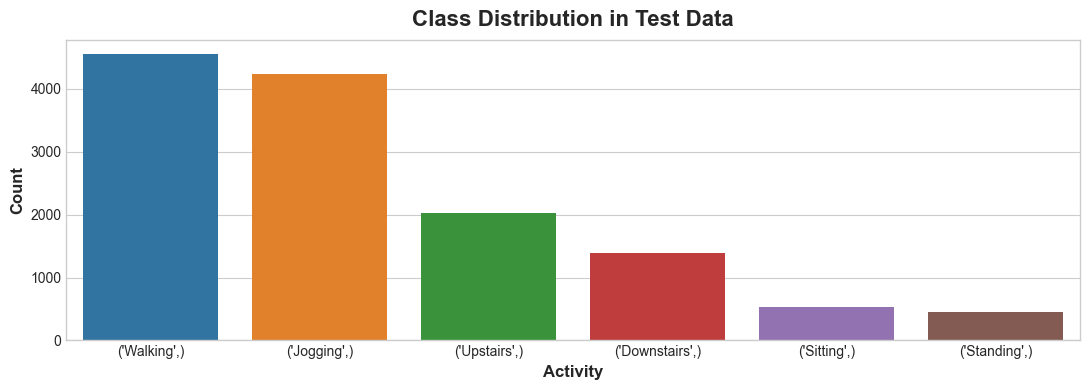

In [55]:
# map activity names to numbers
y_test_df = pd.DataFrame(y_test)
activites = encoder.classes_
y_test_df['activity'] = y_test_df[0].map(lambda x: activites[x])
y_test_df = y_test_df.drop(columns=[0])

# plot class distribution in barplot for y_test
y_test_df = pd.DataFrame(y_test_df.value_counts())
y_test_df['activity'] = y_test_df.index
y_test_df.columns = ['count', 'activity']

sns.barplot(x='activity', y='count', data=y_test_df)
plt.title('Class Distribution in Test Data')
plt.xlabel('Activity')
plt.ylabel('Count')


# Confusion Matrices

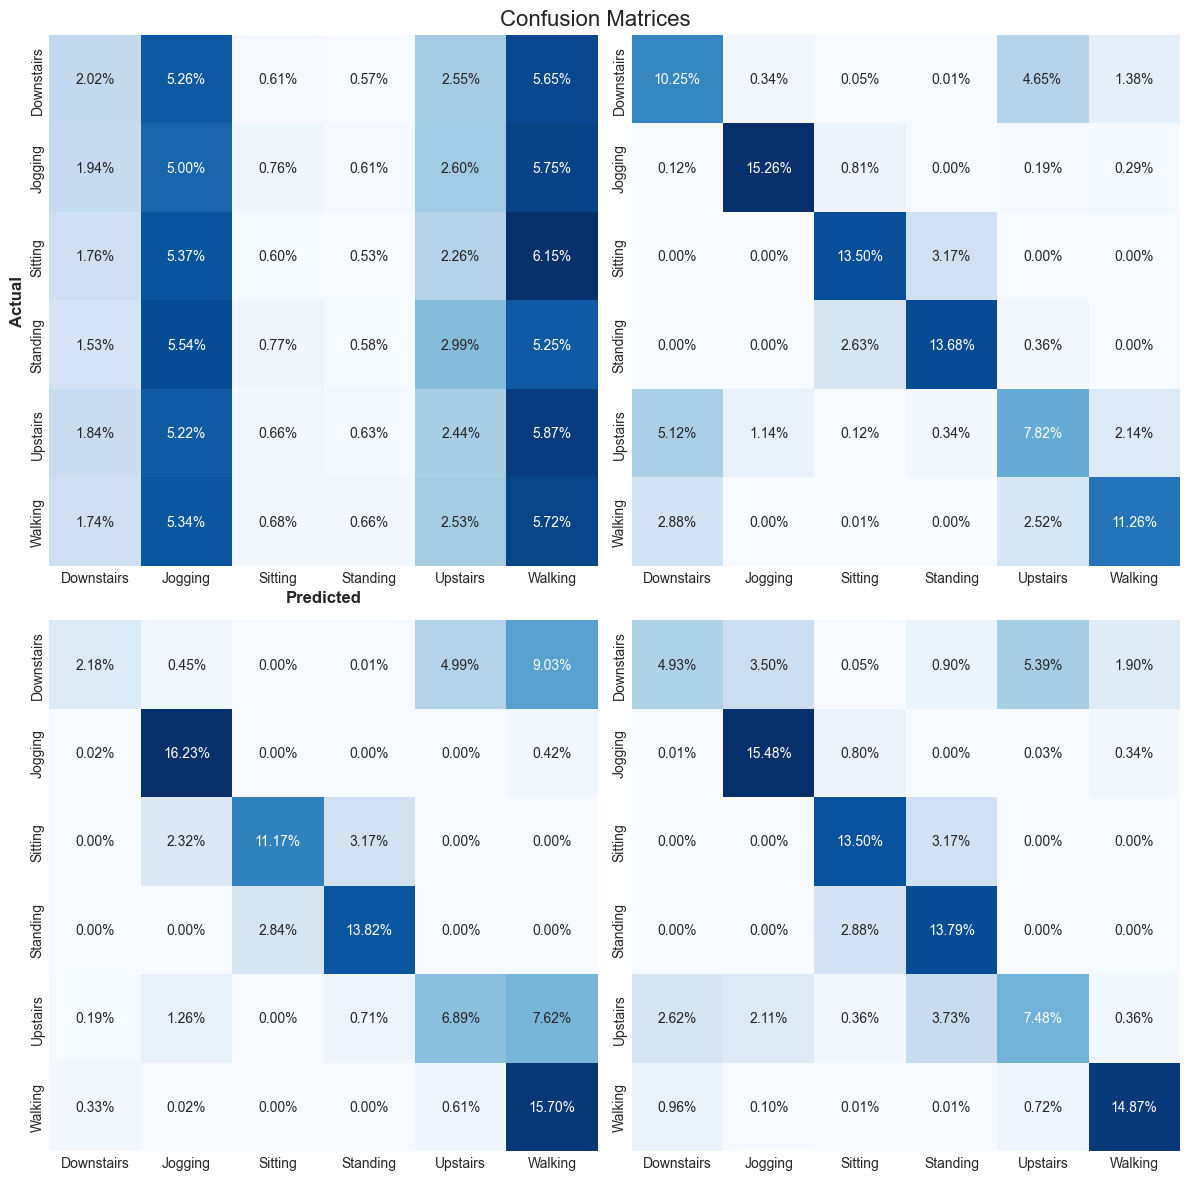

In [66]:
# plot confusion matrices in subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# main title
fig.suptitle('Confusion Matrices', fontsize=16)

predictions = [baseline_random_rate_predictions, lstm_model_predictions, cnn_model_predictions, cnn_lstm_model_predictions]
titles = ['Random Rate Baseline Model', 'LSTM Model', 'CNN Model', 'CNN-LSTM Model']
activities = encoder.classes_

for i in range(4):
    ax[0, 0].set_xlabel('Predicted')
    ax[0, 0].set_ylabel('Actual')
    # create confusion matrix for multiclass classification as percentage
    cm = confusion_matrix(y_test, predictions[i], normalize='true')

    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [v1 for v1 in zip(group_percentages)]
    labels = np.asarray(labels).reshape(6,6)

    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax[i//2, i%2], cbar=False, xticklabels=activities, yticklabels=activities)

# McNemar's Test

In [ ]:
# calculate contingency table for each model
baseline_models_contingency_table = pd.crosstab(baseline_model_1_predictions, baseline_model_2_predictions)
lightgbm_baseline_model_1_contingency_table = pd.crosstab(lightgbm_model_predictions_labels, baseline_model_1_predictions)
lightgbm_baseline_model_2_contingency_table = pd.crosstab(lightgbm_model_predictions_labels, baseline_model_2_predictions)

# calculate McNemar's test for each model
baseline_models_mcnemar_test = mcnemar(baseline_models_contingency_table, exact=False, correction=True)
lightgbm_baseline_model_1_mcnemar_test = mcnemar(lightgbm_baseline_model_1_contingency_table, exact=False, correction=True)
lightgbm_baseline_model_2_mcnemar_test = mcnemar(lightgbm_baseline_model_2_contingency_table, exact=False, correction=True)

# summarize the finding
print('Baseline Models McNemar Test: chi-squared=%.3f, p-value=%.3f' % (baseline_models_mcnemar_test.statistic, baseline_models_mcnemar_test.pvalue))
print('LightGBM vs Baseline Model 1 McNemar Test: chi-squared=%.3f, p-value=%.3f' % (lightgbm_baseline_model_1_mcnemar_test.statistic, lightgbm_baseline_model_1_mcnemar_test.pvalue))
print('LightGBM vs Baseline Model 2 McNemar Test: chi-squared=%.3f, p-value=%.3f' % (lightgbm_baseline_model_2_mcnemar_test.statistic, lightgbm_baseline_model_2_mcnemar_test.pvalue))

Baseline Models McNemar Test: chi-squared=23590.000, p-value=0.000
LightGBM vs Baseline Model 1 McNemar Test: chi-squared=31047.000, p-value=0.000
LightGBM vs Baseline Model 2 McNemar Test: chi-squared=1437.784, p-value=0.000


# Summary
